In [1]:
import pandas as pd
import sklearn
from sklearn import preprocessing
import datetime
from boruta import BorutaPy
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split

In [2]:
# Functions for Feature Generation for Time Series Data
le_day_of_week = preprocessing.LabelEncoder()
le_week_status = preprocessing.LabelEncoder()

def secondsDay(data_frame):
    hour = data_frame.date.dt.hour
    minute = data_frame.date.dt.minute
    seconds = data_frame.date.dt.second
    return hour * 3600 + minute * 60 + seconds
    
def weekStatus(data_frame, label_encoder):
    week_status_DF = pd.DataFrame(columns=['week_status'])
    train_date_DF = pd.DataFrame(columns=['date'])
    train_date_DF = data_frame['date']    
    for date in train_date_DF.items():
        day = date[1].weekday_name
        if day == 'Saturday' or day == 'Sunday':
            week_status_DF =  week_status_DF.append({'week_status': 'Weekend'}, ignore_index=True)
        else:
            week_status_DF =  week_status_DF.append({'week_status': 'Weekday'}, ignore_index=True)
    
    weekstatus_labels = label_encoder.fit_transform(week_status_DF.values.ravel())
    return weekstatus_labels

def dayOfWeek(data_frame, label_encoder):
    day_of_week_label = label_encoder.fit_transform(data_frame.date.dt.weekday_name.values.ravel())
    return day_of_week_label

In [3]:
# Pre-process data
train_data = pd.read_csv('s3://ml-assignment2-data/UCI-electricity/UCI_data.csv', parse_dates=True)

# Generate timeseries eatures for complete dataset
train_data['date'] = train_data['date'].astype('datetime64[ns]')

# Feature Generation for Timeseries Data
# Generate Number of Seconds from Midnight (NSM), 
nsm_series = secondsDay(train_data)
nsm_DF = nsm_series.to_frame()

# Week Status of the data, weekend or weekday
week_status_DF = pd.DataFrame(data=weekStatus(train_data, le_week_status), columns=['week_status'])

# DayOfTheWeek, for each data row
day_of_week_DF = pd.DataFrame(data=dayOfWeek(train_data, le_day_of_week), columns=['day_of_week'])

train_data['nsm'] = nsm_DF['date']
train_data['week_status'] = week_status_DF['week_status']
train_data['day_of_week'] = day_of_week_DF['day_of_week']
train_data =  train_data.drop(columns=['date'])

In [4]:
# SKLEARN to create data partition function, 75% Training, 25% Testing. 
x_train_DF = train_data.drop(columns=['TARGET_energy'])
y_train_DF = pd.DataFrame(train_data['TARGET_energy'], columns=['TARGET_energy'])
print(type(y_train_DF))
print(type(x_train_DF))
x_train_values = x_train_DF.to_numpy().astype('float64')
y_train_values = y_train_DF.to_numpy().astype('float64')

X_train, X_test, y_train, y_test = train_test_split(x_train_values, y_train_values, test_size=.25, random_state=42)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
independent_scaler = preprocessing.StandardScaler()
target_scaler = preprocessing.StandardScaler()

x_train_scaled = independent_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

X_train_scaled_DF = pd.DataFrame(x_train_scaled, columns=x_train_DF.columns)
Y_train_scaled_DF = pd.DataFrame(y_train_scaled, columns=y_train_DF.columns)

In [6]:
# Model & Feature Selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Import Models Single (LR, SVM, ANN, DT)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# Import Models Ensemble (Boosting {Gradient Boosting Machines}, Averaging Methods {Voting and Bagging})
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble  import RandomForestRegressor

In [7]:
rf = RandomForestRegressor(n_estimators=20, criterion='mse')

feat_selector = RFECV(estimator=rf, step=1, cv=KFold(2))
feat_selector.fit(X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel())
feat_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True])

In [8]:
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1])

In [9]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [10]:
ann = MLPRegressor(random_state=0, activation='logistic', solver='sgd', tol=15000, max_iter=500)
lm = LinearRegression()
svr = SVR()
dt = tree.DecisionTreeRegressor()

gmb = GradientBoostingRegressor(random_state=4)
rfg = RandomForestRegressor(random_state=0)

r2 = 'r2'
mse = 'neg_mean_squared_error'
mae = 'neg_mean_absolute_error'

scoring = {}
scoring['r2'] =  r2
scoring['mse'] = mse
scoring['mae'] = mae

In [11]:
# Train Models for Single Methods
single_models = []
single_models.append(('LM', lm))
single_models.append(('SVR', svr))
single_models.append(('ANN', ann))
single_models.append(('DT', dt))

# Train Models for Ensemble Methods
ensemble_models = []
ensemble_models.append(('GMB', gmb))
ensemble_models.append(('RFG', rfg))

In [12]:
def cross_validate_score(models, scoring_type):
    results = []
    names = []
    score = {}
    if scoring_type == 'rmse':
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel(), cv=kfold, scoring = scoring['mse'])
            results.append(cv_results)
            names.append(name)
            rmse = math.sqrt(-cv_results.mean())
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, rmse, cv_results.std())
            print(msg)
    else:
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel(), cv=kfold, scoring = scoring[scoring_type])
            results.append(cv_results)
            names.append(name)
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, cv_results.mean(), cv_results.std())
            print(msg)
    return score

In [13]:
results_r2 = cross_validate_score(single_models, 'r2')

r2: LM: 0.158134 (0.014497)
r2: SVR: 0.243712 (0.021276)
r2: ANN: 0.068974 (0.007114)
r2: DT: 0.242556 (0.105755)


In [14]:
results_mse = cross_validate_score(single_models, 'mse')

mse: LM: -0.841885 (0.075510)
mse: SVR: -0.757105 (0.077624)
mse: ANN: -0.930982 (0.081770)
mse: DT: -0.771863 (0.113931)


In [15]:
results_rmse = cross_validate_score(single_models, 'rmse')

rmse: LM: 0.917543 (0.075510)
rmse: SVR: 0.870118 (0.077624)
rmse: ANN: 0.964874 (0.081770)
rmse: DT: 0.867032 (0.082671)


In [16]:
results_mae = cross_validate_score(single_models, 'mae')

mae: LM: -0.528563 (0.017219)
mae: SVR: -0.370823 (0.018084)
mae: ANN: -0.552813 (0.016507)
mae: DT: -0.380132 (0.027329)


In [17]:
# Performance plotting
import matplotlib.pyplot as plt

def generate_comparison(results, scoring_type):
    labels, data = [*zip(*results.items())]
    fig = plt.figure()
    fig.suptitle('Model Comparison on {}'.format(scoring_type))
    ax = fig.add_subplot(111)
    plt.boxplot(data)
    ax.set_xticklabels(labels)
    plt.show()

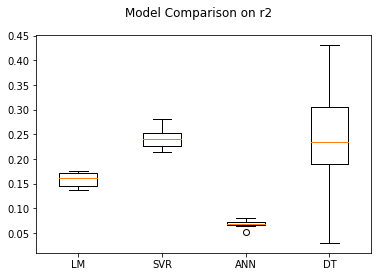

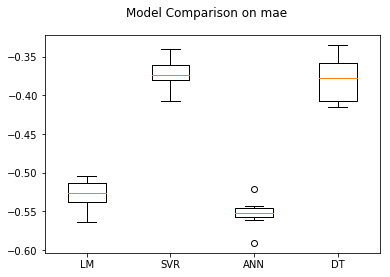

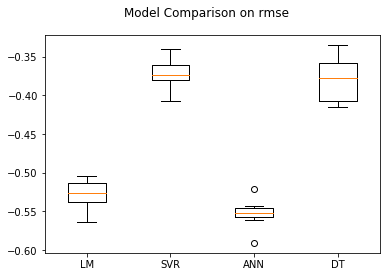

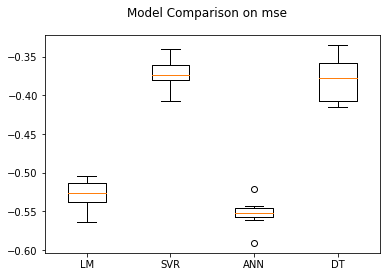

In [18]:
#INIT TODO: Change negative numbers into positive
generate_comparison(results_r2, 'r2')
generate_comparison(results_mae, 'mae')
generate_comparison(results_mae, 'rmse')
generate_comparison(results_mae, 'mse')

In [19]:
# Ensemble Methods

# --- Averaging Methods ---
# Voting (ANNs, CART, SVR, LR)
temp = []
vote = VotingRegressor(single_models)
temp.append(('VOTE', vote))
cross_validate_score(temp, 'r2')
cross_validate_score(temp, 'rmse')
cross_validate_score(temp, 'mse')
cross_validate_score(temp, 'mae')

r2: VOTE: 0.359228 (0.023679)
rmse: VOTE: 0.798818 (0.057596)
mse: VOTE: -0.638805 (0.058191)
mae: VOTE: -0.401578 (0.014729)


{'VOTE': array([-0.40864754, -0.4086826 , -0.40021771, -0.3793387 , -0.38502615,
        -0.39236973, -0.39089903, -0.40807026, -0.40937423, -0.4331527 ])}

In [20]:
# --- Averaging ---
# Bagging (ANN, LM, SVR, CART)
# Voting
# Random Forest Trees (Decision Trees)
# --- Boosting ---
# Gradient Boosting Machines

bagging_models = []
bagging_models.append(('LM', BaggingRegressor(lm)))
bagging_models.append(('SVR', BaggingRegressor(svr)))
bagging_models.append(('DT', BaggingRegressor(dt)))
bagging_models.append(('ANN', BaggingRegressor(ann)))

results_bagging_r2 = cross_validate_score(bagging_models, 'r2')
results_bagging_mse = cross_validate_score(bagging_models, 'mse')
results_bagging_rmse = cross_validate_score(bagging_models, 'rmse')
results_bagging_mae = cross_validate_score(bagging_models, 'mae')

# GMB & RFG (Boosting & Averaging)
results_bagging_r2 = cross_validate_score(ensemble_models, 'r2')
results_bagging_mse = cross_validate_score(ensemble_models, 'mse')
results_bagging_rmse = cross_validate_score(ensemble_models, 'rmse')
results_bagging_mae = cross_validate_score(ensemble_models, 'mae')

r2: LM: 0.157614 (0.014361)
r2: SVR: 0.248280 (0.021733)
r2: DT: 0.523344 (0.036481)
r2: ANN: 0.075715 (0.008376)
mse: LM: -0.842274 (0.075395)
mse: SVR: -0.752084 (0.077036)
mse: DT: -0.473656 (0.048235)
mse: ANN: -0.925056 (0.080585)
rmse: LM: 0.917834 (0.075473)
rmse: SVR: 0.867870 (0.077430)
rmse: DT: 0.689802 (0.052229)
rmse: ANN: 0.961908 (0.080687)
mae: LM: -0.528084 (0.017714)
mae: SVR: -0.372684 (0.017661)
mae: DT: -0.331216 (0.012572)
mae: ANN: -0.558040 (0.017515)
r2: GMB: 0.307916 (0.016356)
r2: RFG: 0.569899 (0.029771)
mse: GMB: -0.691852 (0.059601)
mse: RFG: -0.429830 (0.044561)
rmse: GMB: 0.831776 (0.059601)
rmse: RFG: 0.655615 (0.044561)
mae: GMB: -0.453823 (0.014155)
mae: RFG: -0.314317 (0.015034)


In [29]:
# Train Model with Testing Set 
# RF Train on test Data
x_test_scaled = independent_scaler.fit_transform(X_train)
y_test_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

X_test_scaled_DF = pd.DataFrame(x_test_scaled, columns=x_train_DF.columns)
Y_test_scaled_DF = pd.DataFrame(y_test_scaled, columns=y_train_DF.columns)

def cross_validate_score_test(models, scoring_type, X_test_data, Y_test_data):
    results = []
    names = []
    score = {}
    if scoring_type == 'rmse':
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_test_data.to_numpy(), Y_test_data.to_numpy().ravel(), cv=kfold, scoring = scoring['mse'])
            results.append(cv_results)
            names.append(name)
            rmse = math.sqrt(-cv_results.mean())
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, rmse, cv_results.std())
            print(msg)
    else:
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_test_data.to_numpy(), Y_test_data.to_numpy().ravel(), cv=kfold, scoring = scoring[scoring_type])
            results.append(cv_results)
            names.append(name)
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, cv_results.mean(), cv_results.std())
            print(msg)
    return score


model = []
model.append(('RF', rf))
results_randomforest_r2 = cross_validate_score_test(model, 'r2', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_rmse = cross_validate_score_test(model, 'rmse', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_mse = cross_validate_score_test(model, 'mse', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_mae = cross_validate_score_test(model, 'mae', X_test_scaled_DF, Y_test_scaled_DF)

r2: RF: 0.554325 (0.029282)
rmse: RF: 0.670464 (0.046823)
mse: RF: -0.445178 (0.044867)
mae: RF: -0.321067 (0.013818)


In [62]:
model = rf.fit(x_train_scaled, y_train_scaled.ravel())

In [63]:
predY = rf.predict(x_test_scaled)

In [64]:
from IPython.display import FileLink, FileLinks
import numpy as np
#Unscale results, and export as CSV
predY_DF = pd.DataFrame(predY)
predY_unscaled = target_scaler.inverse_transform(predY_DF)
predY_DF_unscaled = pd.DataFrame(predY_unscaled)
predY_DF_unscaled
csv = predY_DF_unscaled.to_csv('predictedY.csv', index=False)

In [66]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_scaled, predY)

In [67]:
r2

0.9332059521993651